In [1]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform

# Comment here to add in for either mac or linux computer
if platform.system() == "Linux":   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
elif platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])
elif platform.system() == "Windows":
    print('No windows repositories defined')

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch
from neuropy.utils import plot_util
from neuropy.utils.signal_process import WaveletSg
from neuropy.plotting.spikes import plot_raster, plot_binned_raster
from neuropy.plotting.signals import plot_signal_w_epochs, plot_spectrogram

from tracefc.io.session_directory import get_session_dir

In [2]:
# Define a class for a typical recording or set of recordings
from neuropy.core.session import ProcessData
    
def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

In [3]:
animal, sess_name = 'Han', 'training'
sess_dir = get_session_dir(animal, sess_name)
sess = sess_use(sess_dir)
print(sess.recinfo)

filename: /data2/Trace_FC/Recording_Rats/Han/2022_08_03_training/Han_training.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250



In [4]:
print(sess.eegfile)

duration: 12444.12 seconds 
duration: 3.46 hours 



# Preprocess Ephys data
Identify artifacts:  
- disconnects  
- filtering  
  
Send to event files to check in Neuroscope  
Write `dead_times.txt` file for spyking-circus and `artifacts.npy` file for my own analysis.

### Identify disconnect and motion artifacts

In [5]:
from neuropy.analyses.artifact import detect_artifact_epochs
signal = sess.eegfile.get_signal()
buffer_add = 0.25  # seconds, None = don't add

art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
if art_epochs_file.exists():
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('Existing artifact epochs file loaded')
else:
    # art_epochs = detect_artifact_epochs(signal, thresh=8, 
    #                                 edge_cutoff=3, merge=6)

    # Pick a particular channel with the code below
    art_epochs = detect_artifact_epochs(signal.time_slice(channel_id=26), thresh=8, 
                                    edge_cutoff=3, merge=6)

    if buffer_add is not None:  # Add in buffer to prevent erroneous detection of start/stop of artifact as SWRs
        art_epochs.add_epoch_buffer(buffer_add)
    sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
    art_epochs.save(art_epochs_file)

print(f'Total artifact time = {art_epochs.durations.sum():0.1F} seconds')
art_epochs.to_dataframe()

Existing artifact epochs file loaded
Total artifact time = 109.1 seconds


,start,stop,label,duration
0,159.7436,170.1324,None,10.3888
1,408.2588,417.1892,None,8.9304
2,859.7700,861.2836,None,1.5136
3,1131.6012,1133.1612,None,1.5600
4,1388.3636,1389.8148,None,1.4512
5,1428.2516,1440.1052,None,11.8536
6,1606.8492,1608.3668,None,1.5176
7,1857.1372,1858.7028,None,1.5656
8,2132.0428,2133.4652,None,1.4224
9,2508.8548,2516.5156,None,7.6608


/home/bowenw/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


<Axes: >

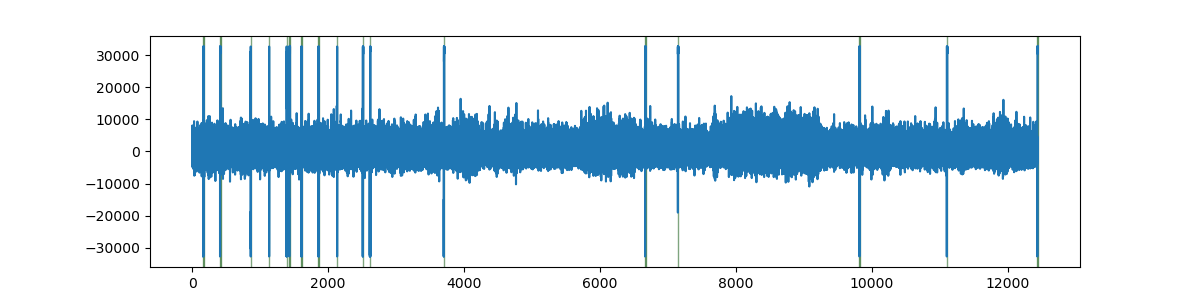

In [6]:
%matplotlib widget

chan_plot = 25
plot_signal_w_epochs(signal, chan_plot, art_epochs)

## Define probe group

/data2/Trace_FC/Recording_Rats/Han/2022_08_03_training/Han_training.probegroup.npy saved


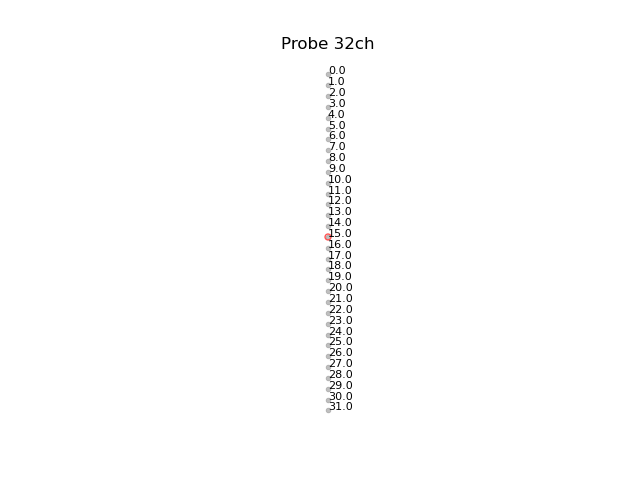

In [7]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe
shank = Shank()
shank = shank.auto_generate(columns=1, contacts_per_column=32, xpitch=0,
                   ypitch=50, channel_id=np.arange(31, -1, -1))
shank.set_disconnected_channels(sess.recinfo.skipped_channels)
probe = Probe(shank)
prbgrp = ProbeGroup()
prbgrp.add_probe(probe)
plot_probe(prbgrp)
prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
sess.prbgrp = prbgrp

# Detect Theta epochs

In [8]:
from neuropy.analyses.oscillations import detect_theta_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
theta_channel = 8
# use this if you don't know theta channel
if theta_channel is None:
    theta_epochs, theta_power = detect_theta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=theta_channel)
    theta_epochs, theta_power = detect_theta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
sess.recinfo.write_epochs(theta_epochs, ext='tha')
theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
theta_epochs.save(theta_epochs_file)

Best channel for theta: [8]
960 epochs remaining with durations within (1,20)
/data2/Trace_FC/Recording_Rats/Han/2022_08_03_training/Han_training.theta_epochs.npy saved


## Detect SWR Epochs

In [9]:
from neuropy.analyses.oscillations import detect_ripple_epochs
ripple_channel = 8
thresh = (2, None)  # conservative but good
edge_cutoff = 0.5
exclude_theta_epochs = False  # make this true if you end up with a lot of false positive ripples as gamma events during theta

if not exclude_theta_epochs:
    ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff, ignore_epochs=art_epochs)
else:
    ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff,
                                         ignore_epochs=art_epochs.__add__(theta_epochs))
sess.recinfo.write_epochs(ripple_epochs, ext='swr')
ripple_epochs_file = sess.filePrefix.with_suffix(".ripple_epochs.npy")
ripple_epochs.save(ripple_epochs_file)

Selected channels for ripples: [8]
8013 epochs remaining with durations within (0.05,0.45)
/data2/Trace_FC/Recording_Rats/Han/2022_08_03_training/Han_training.ripple_epochs.npy saved


In [10]:
# Convert ripple epochs to binned ripple rate
t, rip_bool = ripple_epochs.to_point_process()
from neuropy.core.neurons import BinnedSpiketrain, Neurons
rips = Neurons(t[None, rip_bool], t_stop=50*60)

In [11]:
bin_size_sec = 10
binned_rips = rips.get_binned_spiketrains(bin_size=bin_size_sec)

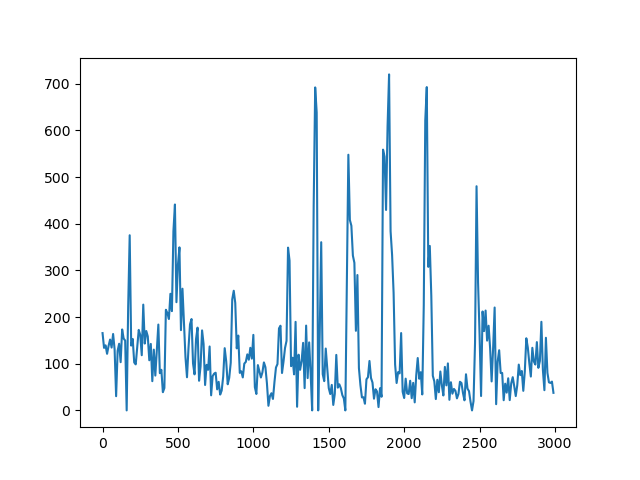

In [12]:
_, ax = plt.subplots()
ax.plot(binned_rips.time, binned_rips.firing_rate[0])

## Detect Delta

In [13]:
from neuropy.analyses.oscillations import detect_hpc_delta_wave_epochs
min_dur = 0.05 
max_dur = 0.5   
ignore_epochs = None  
delta_channel = 8 

freq_band = (0.5, 4.25)

if delta_channel is not None:
    signal_use = signal.time_slice(channel_id=delta_channel)
else:
    signal_use = signal

delta_epochs = detect_hpc_delta_wave_epochs(
    signal_use, freq_band=freq_band, min_dur=min_dur, max_dur=max_dur, ignore_epochs=ignore_epochs
)
sess.recinfo.write_epochs(delta_epochs, ext='dta')
delta_epochs_file = sess.filePrefix.with_suffix(".delta_epochs.npy")
delta_epochs.save(delta_epochs_file)

386 delta waves detected
/data2/Trace_FC/Recording_Rats/Han/2022_08_03_training/Han_training.delta_epochs.npy saved


In [14]:
#Beta
from neuropy.analyses.oscillations import detect_beta_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
beta_channel = 8
  
if beta_channel is None:
    beta_epochs, beta_power = detect_beta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=beta_channel)
    beta_epochs, beta_power = detect_beta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
sess.recinfo.write_epochs(beta_epochs, ext='bta')
beta_epochs_file = sess.filePrefix.with_suffix(".beta_epochs.npy")
beta_epochs.save(beta_epochs_file)

Best channel for beta: [8]
874 epochs remaining with durations within (1,20)
/data2/Trace_FC/Recording_Rats/Han/2022_08_03_training/Han_training.beta_epochs.npy saved


In [15]:
# Gamma
from neuropy.analyses.oscillations import detect_gamma_epochs
from neuropy.analyses.oscillations import Gamma
band=(40, 80)
lowthresh = 0.5 
highthresh = 5
minDistance = 200
minDuration = 100
gamma_channel = 8

# Use this if you don't know the specific channel for gamma detection
if gamma_channel is None:
    signal_use = signal.time_slice(channel_id=gamma_channel)
else:
    # If a specific channel for gamma is known
    signal_use = signal

gammadetect = Gamma()
# gammadetect.get_peak_intervals(signal.traces, lowthresh=lowthresh, highthresh=highthresh, minDistance=minDistance, minDuration=minDuration)
peakevents, gamma_amp = Gamma().get_peak_intervals(signal_use.traces[gamma_channel, :], band=band, lowthresh=lowthresh, highthresh=highthresh, 
                                        minDistance=minDistance, minDuration=minDuration, return_amplitude=True)
gamma_epochs = Epoch(pd.DataFrame({"start" : peakevents[:, 0]/sess.eegfile.sampling_rate, "stop": peakevents[:, 1]/sess.eegfile.sampling_rate,
                   "label": ""}))
sess.recinfo.write_epochs(gamma_epochs, ext='gma')
gamma_epochs_file = sess.filePrefix.with_suffix(".gamma_epochs.npy")
gamma_epochs.save(gamma_epochs_file)

/data2/Trace_FC/Recording_Rats/Han/2022_08_03_training/Han_training.gamma_epochs.npy saved


# Wavelet Analysis

### Start with Theta

In [16]:
# Run wavelet on theta range
theta_range = np.arange(4, 14, 0.25)  # How do I select these? 0.25Hz seems good to start
wv_theta = WaveletSg(signal.time_slice(channel_id=theta_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=theta_range, sigma=None)

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

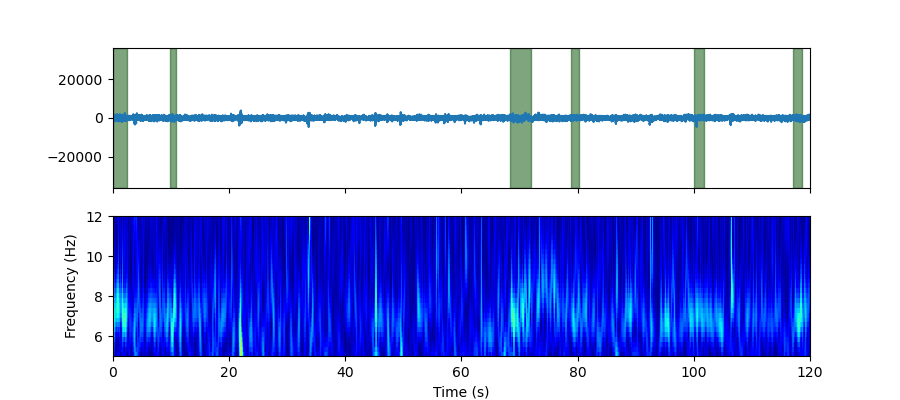

In [17]:
# Sanity check code - does wavelet align well with actual theta epochs?
_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 120]
theta_freq_lims = [5, 12]

plot_signal_w_epochs(signal, theta_channel, theta_epochs, ax=ax[0])

plot_spectrogram(wv_theta, time_lims=time_to_plot, freq_lims=theta_freq_lims, ax=ax[1])

### Mean spectrogram at theta starts

Events [  0 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352
 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370
 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388
 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406
 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424
 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442
 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460
 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478
 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496
 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514
 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532
 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549 550
 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567 568
 569 570 571 572 573 574 575 576 577 578 579

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

Text(0.5, 0, 'Time from Theta epoch start (sec)')

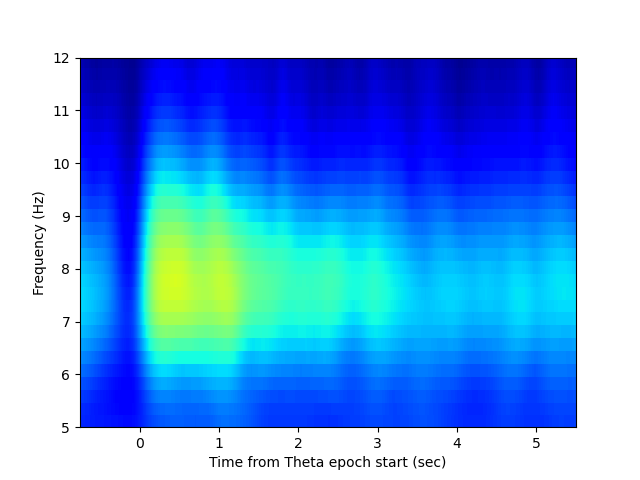

In [18]:
theta_buffer_sec = (0.75, 5.5)
wv_theta_mean = wv_theta.get_pe_mean_spec(theta_epochs.starts, buffer_sec=theta_buffer_sec)
ax = plot_spectrogram(wv_theta_mean, time_lims=np.multiply(theta_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from Theta epoch start (sec)')

### Try out SWRs

In [19]:
swr_range = np.arange(125, 275, 5)
wv_swr = WaveletSg(signal.time_slice(channel_id=ripple_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=swr_range, sigma=None)

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

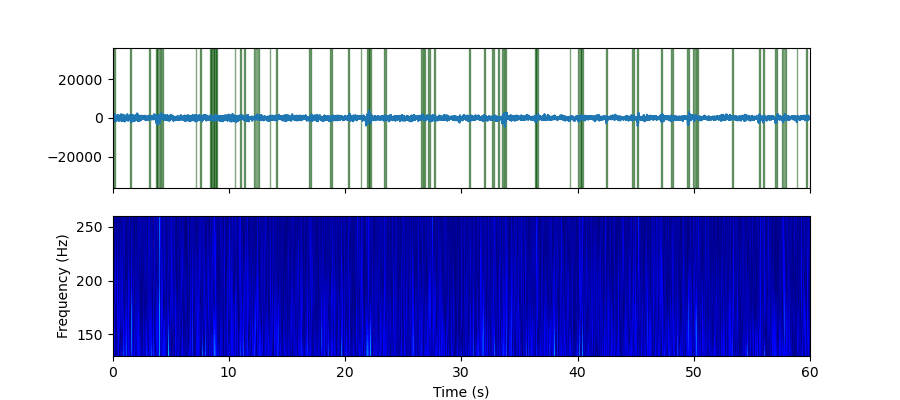

In [20]:
# Sanity check code - does wavelet align well with actual SWR epochs?
_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 60]
swr_freq_lims = [130, 260]

plot_signal_w_epochs(signal, theta_channel, ripple_epochs, ax=ax[0])

plot_spectrogram(wv_swr, time_lims=time_to_plot, freq_lims=swr_freq_lims, ax=ax[1])

### Delta

In [21]:
delta_range = np.arange(0.5, 4.25, 0.1)
wv_delta = WaveletSg(signal.time_slice(channel_id=delta_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=delta_range, sigma=None)

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(0…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

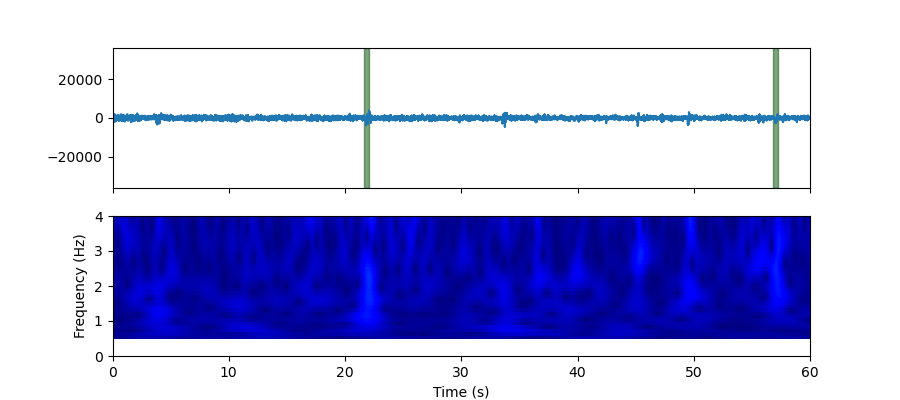

In [22]:
_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 60]
delta_freq_lims = [0.5, 4.25]

plot_signal_w_epochs(signal, delta_channel, delta_epochs, ax=ax[0])

plot_spectrogram(wv_delta, time_lims=time_to_plot, freq_lims=delta_freq_lims, ax=ax[1])

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

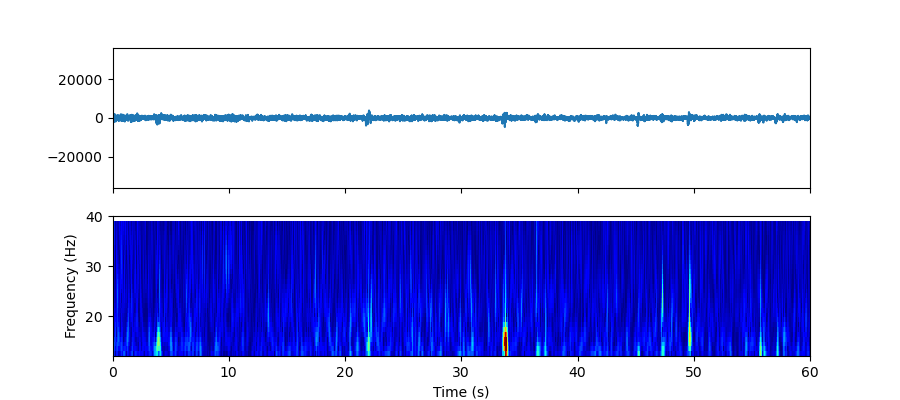

In [23]:
## Beta
beta_range = np.arange(12, 40, 1)  # How do I select these? 
wv_beta = WaveletSg(signal.time_slice(channel_id=beta_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=beta_range, sigma=None)

_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 60]
beta_freq_lims = [12, 40]

plot_signal_w_epochs(signal, beta_channel, beta_epochs, ax=ax[0])

plot_spectrogram(wv_beta, time_lims=time_to_plot, freq_lims=beta_freq_lims, ax=ax[1])

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(4…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

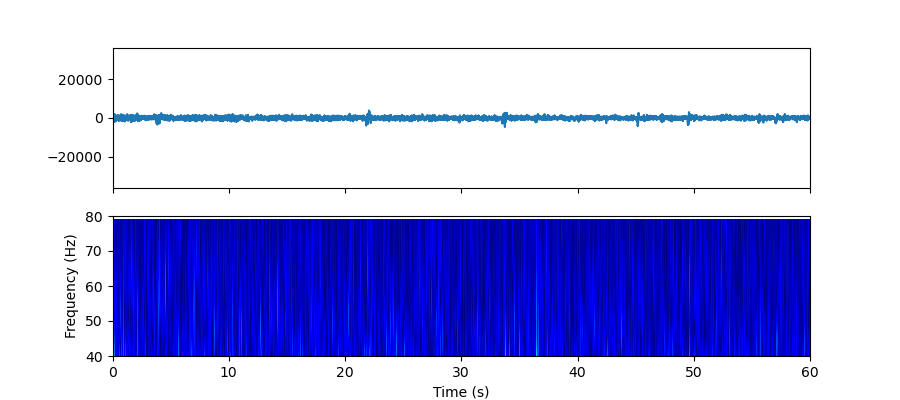

In [24]:
gamma_range = np.arange(40, 80, 1)
wv_gamma = WaveletSg(signal.time_slice(channel_id=gamma_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=gamma_range, sigma=None)

_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 60]
gamma_freq_lims = [40, 80]

plot_signal_w_epochs(signal, gamma_channel, gamma_epochs, ax=ax[0])

plot_spectrogram(wv_gamma, time_lims=time_to_plot, freq_lims=gamma_freq_lims, ax=ax[1])

### Mean spectrogram at all ripples

Events [3800 3801 3802 ... 8010 8011 8012] are outside of data range and were dropped


interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

Text(0.5, 0, 'Time from Ripple Peak (sec)')

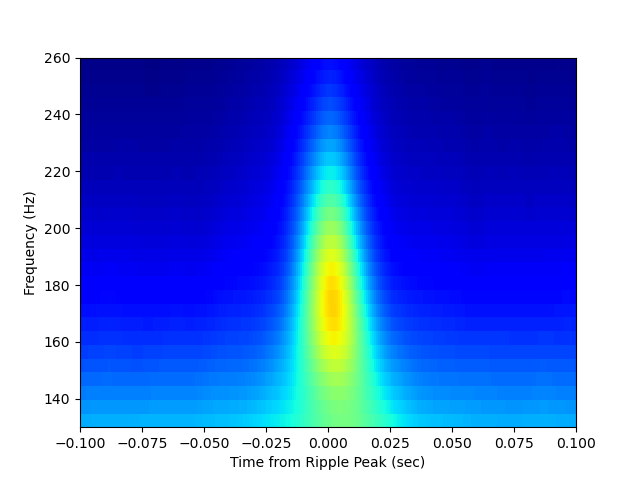

In [25]:
ripple_buffer_sec = (0.1, 0.1)
wv_swr_mean = wv_swr.get_pe_mean_spec(ripple_epochs.to_dataframe()['peak_time'].values, buffer_sec=ripple_buffer_sec)
ax = plot_spectrogram(wv_swr_mean, time_lims=np.multiply(ripple_buffer_sec, (-1, 1)), freq_lims=swr_freq_lims)
ax.set_xlabel('Time from Ripple Peak (sec)')

## Peri-USV analyses

In [26]:
# Import USV epochs (from Sync_USV_and_Ephys notebook).
usv_epochs_file = sess.filePrefix.with_suffix(".usv_epochs.npy")
usv_epochs = Epoch(epochs=None, file=usv_epochs_file)
usv_epochs


107 epochs
Snippet: 
         start        stop  Begin_Time   Freq_Min  Duration  Freq_Range  Score  \
0  446.819063  446.912341  446.819063  32.435751  0.093278   45.195929    1.0   
1  446.917153  446.991495  446.917153  50.405216  0.074342   34.441476    1.0   
2  447.052188  447.165813  447.052188  43.482818  0.113625   16.668958    1.0   
3  447.256451  447.308525  447.256451  46.914662  0.052074   11.521191    1.0   
4  447.305980  447.444434  447.305980  32.451890  0.138454    9.315006    1.0   

   Accept  nrec  t_start_eeg  t_stop_eeg label  
0       1     2   860.598041  860.691307        
1       1     2   860.696118  860.770450        
2       1     2   860.831136  860.944746        
3       1     2   861.035373  861.087440        
4       1     2   861.084896  861.223332        

In [27]:
usv_epochs._epochs

,start,stop,Begin_Time,Freq_Min,Duration,Freq_Range,Score,Accept,nrec,t_start_eeg,t_stop_eeg,label
0,446.819063,446.912341,446.819063,32.435751,0.093278,45.195929,1.000000,1,2,860.598041,860.691307,
1,446.917153,446.991495,446.917153,50.405216,0.074342,34.441476,1.000000,1,2,860.696118,860.770450,
2,447.052188,447.165813,447.052188,43.482818,0.113625,16.668958,1.000000,1,2,860.831136,860.944746,
3,447.256451,447.308525,447.256451,46.914662,0.052074,11.521191,1.000000,1,2,861.035373,861.087440,
4,447.305980,447.444434,447.305980,32.451890,0.138454,9.315006,1.000000,1,2,861.084896,861.223332,
...,...,...,...,...,...,...,...,...,...,...,...,...
102,1248.889305,1249.515682,1248.889305,14.512427,0.626377,7.111111,1.000000,1,3,1624.587944,1625.214228,
103,1249.601622,1250.095759,1249.601622,14.055556,0.494137,7.777778,1.000000,1,3,1625.300156,1625.794220,
104,1250.187977,1250.820431,1250.187977,13.728436,0.632454,8.777778,1.000000,1,3,1625.886424,1626.518784,
105,1250.920864,1251.461750,1250.920864,15.388889,0.540886,7.000000,1.000000,1,3,1626.619202,1627.160008,


In [28]:
usv_epochs._epochs.Duration.mean()

0.36803571096141957

In [29]:
short_usv_epochs = usv_epochs._epochs[usv_epochs._epochs.Duration<=0.15]
short_usv_epochs

,start,stop,Begin_Time,Freq_Min,Duration,Freq_Range,Score,Accept,nrec,t_start_eeg,t_stop_eeg,label
0,446.819063,446.912341,446.819063,32.435751,0.093278,45.195929,1.000000,1,2,860.598041,860.691307,
1,446.917153,446.991495,446.917153,50.405216,0.074342,34.441476,1.000000,1,2,860.696118,860.770450,
2,447.052188,447.165813,447.052188,43.482818,0.113625,16.668958,1.000000,1,2,860.831136,860.944746,
3,447.256451,447.308525,447.256451,46.914662,0.052074,11.521191,1.000000,1,2,861.035373,861.087440,
4,447.305980,447.444434,447.305980,32.451890,0.138454,9.315006,1.000000,1,2,861.084896,861.223332,
5,447.784549,447.848949,447.784549,40.296105,0.064399,13.114548,1.000000,1,2,861.563404,861.627795,
6,448.285269,448.343698,448.285269,37.722222,0.058429,34.808706,1.000000,1,2,862.064059,862.122481,
7,448.964581,449.061268,448.964581,29.878007,0.096687,10.295533,0.590221,1,2,862.743285,862.839959,
9,449.751268,449.811268,449.751268,47.527491,0.060000,30.273769,0.590221,1,2,863.529871,863.589864,
10,450.068696,450.141268,450.068696,29.755441,0.072572,8.457045,0.590221,1,2,863.847259,863.919822,


In [30]:
long_usv_epochs_filtered = usv_epochs._epochs[(usv_epochs._epochs.Duration>0.15)]
long_usv_epochs_filtered

,start,stop,Begin_Time,Freq_Min,Duration,Freq_Range,Score,Accept,nrec,t_start_eeg,t_stop_eeg,label
8,449.371502,449.523304,449.371502,29.179301,0.151803,10.663230,0.590221,1,2,863.150153,863.301937,
28,463.920178,464.227247,463.920178,26.686053,0.307069,7.486827,0.590221,1,2,877.696972,878.004002,
30,464.856047,465.114140,464.856047,28.611111,0.258093,5.333333,1.000000,1,2,878.632722,878.890782,
42,472.282122,473.587801,472.282122,18.841838,1.305679,15.198167,0.590221,1,2,886.057849,887.363361,
46,475.482441,476.308599,475.482441,15.953751,0.826158,17.233534,0.590221,1,2,889.257760,890.083812,
47,477.281268,477.641730,477.281268,13.625000,0.360462,14.904782,0.590221,1,2,891.056357,891.416773,
48,478.903605,479.962644,478.903605,14.115263,1.059039,15.272480,0.590221,1,2,892.678487,893.737391,
49,481.472647,482.398992,481.472647,16.321449,0.926345,10.002148,0.590221,1,2,895.247201,896.173428,
50,483.281268,484.117283,483.281268,13.625000,0.836015,14.291953,0.590221,1,2,897.055591,897.891499,
51,488.807437,490.112468,488.807437,16.934278,1.305032,13.556558,0.590221,1,2,902.581054,903.885919,


In [31]:
long_usv_epochs_filtered.Duration.mean()

0.6410260991420925

In [32]:
art_epochs

17 epochs
Snippet: 
        start       stop label
0   159.7436   170.1324  None
1   408.2588   417.1892  None
2   859.7700   861.2836  None
3  1131.6012  1133.1612  None
4  1388.3636  1389.8148  None

## Theta mean spectrogram

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

Text(0.5, 0, 'Time from USV start(sec)')

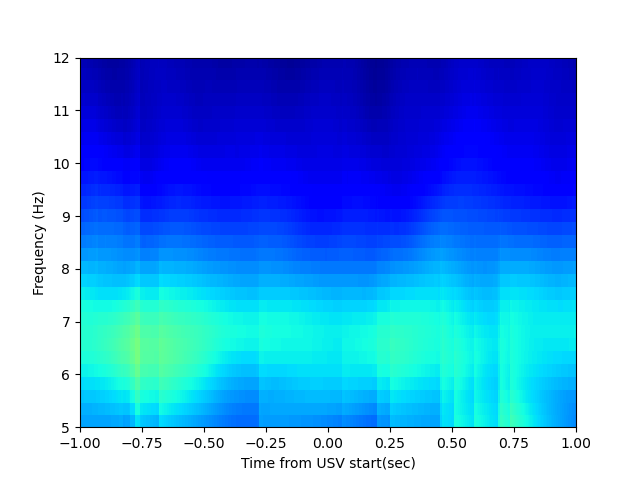

In [50]:
# Example code to plot theta at USV starts
usv_buffer_sec = (1,1)
wv_theta_mean = wv_theta.get_pe_mean_spec(usv_epochs.to_dataframe()['t_start_eeg'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_theta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from USV start(sec)')

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

Text(0.5, 0, 'Time from USV start (sec)')

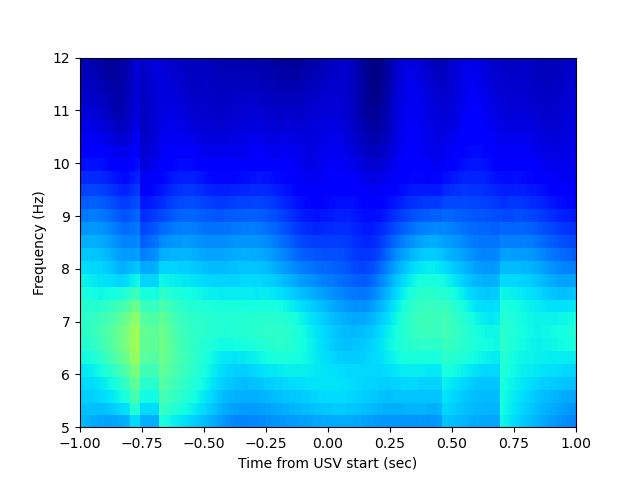

In [51]:
# long usv
usv_buffer_sec = (1,1)
wv_theta_mean = wv_theta.get_pe_mean_spec(long_usv_epochs_filtered['t_start_eeg'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_theta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from USV start (sec)')

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

Text(0.5, 0, 'Time from USV start (sec)')

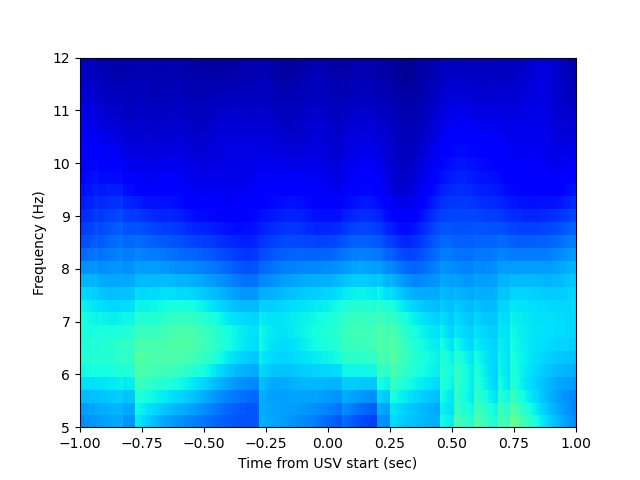

In [53]:
# short usv
usv_buffer_sec = (1,1)
wv_theta_mean = wv_theta.get_pe_mean_spec(short_usv_epochs['t_start_eeg'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                         print_ignored_frames=False)
ax = plot_spectrogram(wv_theta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from USV start (sec)')

## Ripple mean spectrogram

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

Text(0.5, 0, 'Time from USV start (sec)')

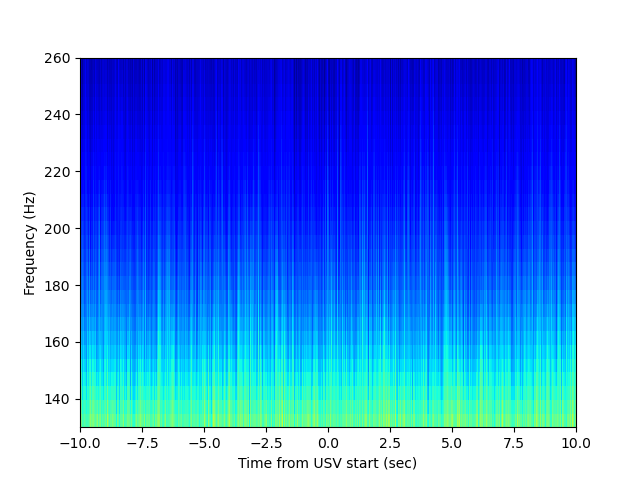

In [36]:
# All
usv_buffer_sec = (10, 10)
wv_swr_mean = wv_swr.get_pe_mean_spec(usv_epochs.to_dataframe()['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_swr_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=swr_freq_lims)
ax.set_xlabel('Time from USV start (sec)')

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

Text(0.5, 0, 'Time from USV start (sec)')

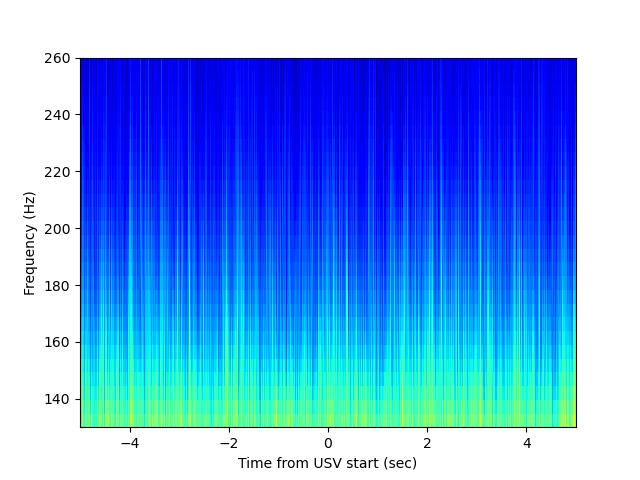

In [37]:
# short USV
usv_buffer_sec = (5,5)
wv_swr_mean = wv_swr.get_pe_mean_spec(short_usv_epochs['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_swr_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=swr_freq_lims)
ax.set_xlabel('Time from USV start (sec)')

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

Text(0.5, 0, 'Time from USV start (sec)')

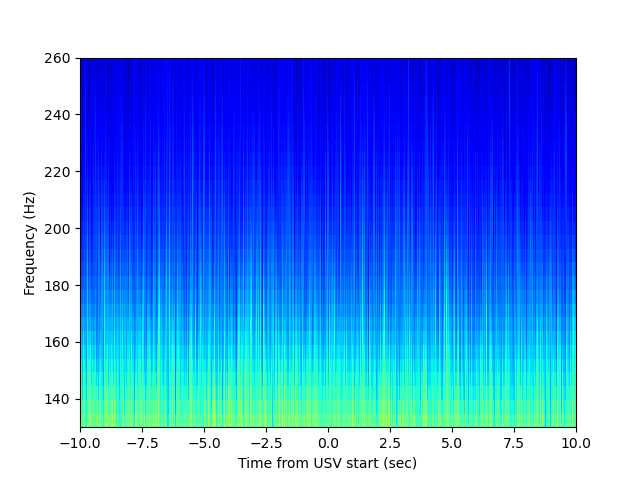

In [38]:
#long USV
usv_buffer_sec = (10, 10)
wv_swr_mean = wv_swr.get_pe_mean_spec(long_usv_epochs_filtered['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_swr_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=swr_freq_lims)
ax.set_xlabel('Time from USV start (sec)')

## Delta

In [39]:
usv_epochs.to_dataframe().drop(index=72)

,start,stop,Begin_Time,Freq_Min,Duration,Freq_Range,Score,Accept,nrec,t_start_eeg,t_stop_eeg,label,duration
0,446.819063,446.912341,446.819063,32.435751,0.093278,45.195929,1.000000,1,2,860.598041,860.691307,,0.093278
1,446.917153,446.991495,446.917153,50.405216,0.074342,34.441476,1.000000,1,2,860.696118,860.770450,,0.074342
2,447.052188,447.165813,447.052188,43.482818,0.113625,16.668958,1.000000,1,2,860.831136,860.944746,,0.113625
3,447.256451,447.308525,447.256451,46.914662,0.052074,11.521191,1.000000,1,2,861.035373,861.087440,,0.052074
4,447.305980,447.444434,447.305980,32.451890,0.138454,9.315006,1.000000,1,2,861.084896,861.223332,,0.138454
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,1248.889305,1249.515682,1248.889305,14.512427,0.626377,7.111111,1.000000,1,3,1624.587944,1625.214228,,0.626377
103,1249.601622,1250.095759,1249.601622,14.055556,0.494137,7.777778,1.000000,1,3,1625.300156,1625.794220,,0.494137
104,1250.187977,1250.820431,1250.187977,13.728436,0.632454,8.777778,1.000000,1,3,1625.886424,1626.518784,,0.632454
105,1250.920864,1251.461750,1250.920864,15.388889,0.540886,7.000000,1.000000,1,3,1626.619202,1627.160008,,0.540886


interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(0…

Text(0.5, 0, 'Time from USV start(sec)')

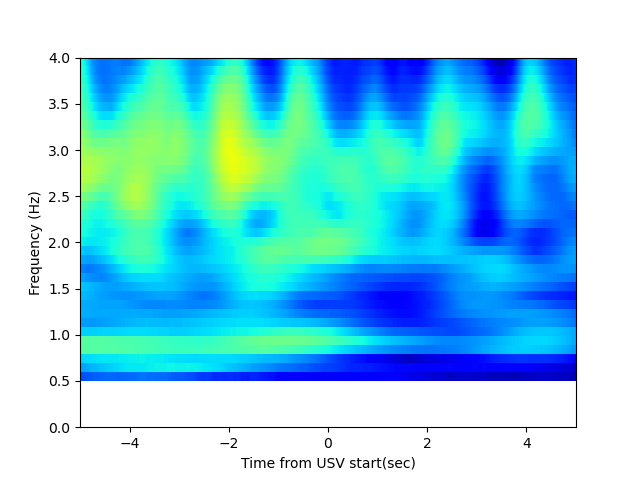

In [40]:
#all Delta
usv_buffer_sec = (5, 5)
wv_delta_mean = wv_delta.get_pe_mean_spec(usv_epochs.to_dataframe().drop(index=72)['start'].values[0:72], buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs, 
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_delta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=delta_freq_lims)
ax.set_xlabel('Time from USV start(sec)')

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(0…

Text(0.5, 0, 'Time from USV start(sec)')

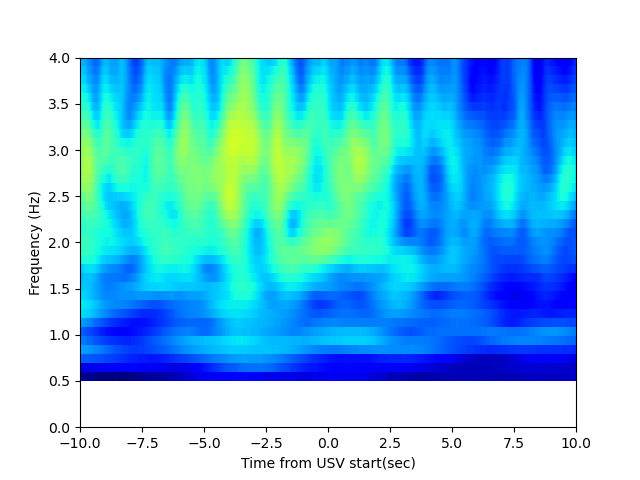

In [41]:
# short Delta
usv_buffer_sec = (10, 10)
wv_delta_mean = wv_delta.get_pe_mean_spec(short_usv_epochs['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_delta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=delta_freq_lims)
ax.set_xlabel('Time from USV start(sec)')

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(0…

Text(0.5, 0, 'Time from USV start(sec)')

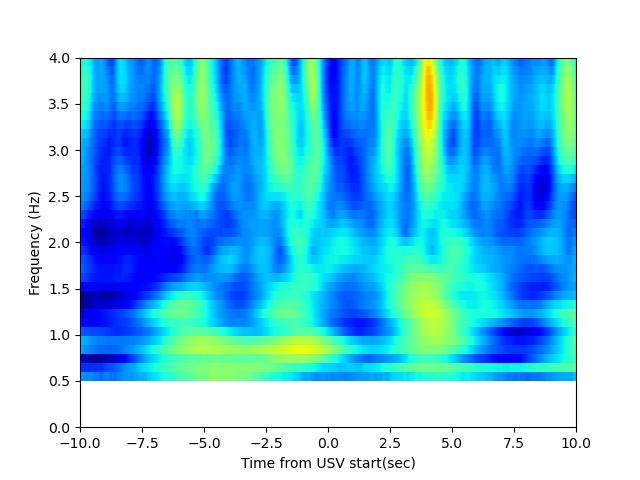

In [42]:
# long Delta
usv_buffer_sec = (10, 10)
wv_delta_mean = wv_delta.get_pe_mean_spec(long_usv_epochs_filtered['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_delta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=delta_freq_lims)
ax.set_xlabel('Time from USV start(sec)')

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

Text(0.5, 0, 'Time from USV start(sec)')

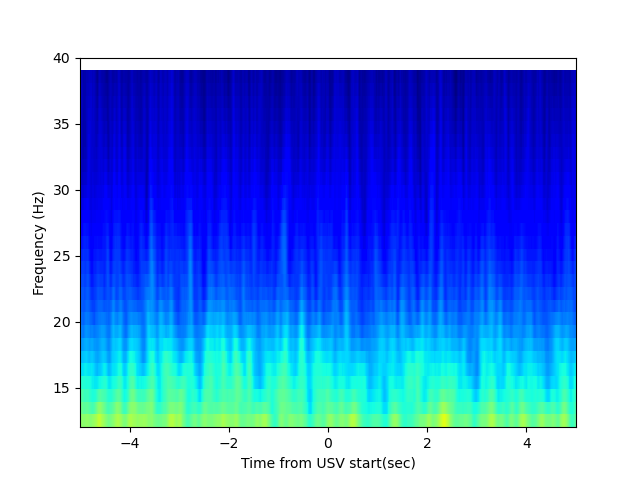

In [43]:
#Beta
usv_buffer_sec = (5,5)
wv_beta_mean = wv_beta.get_pe_mean_spec(usv_epochs.to_dataframe()['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_beta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=beta_freq_lims)
ax.set_xlabel('Time from USV start(sec)')

/data/GitHub/NeuroPy/neuropy/plotting/signals.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, ax = plt.subplots(1, 1)


interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

Text(0.5, 0, 'Time from USV start(sec)')

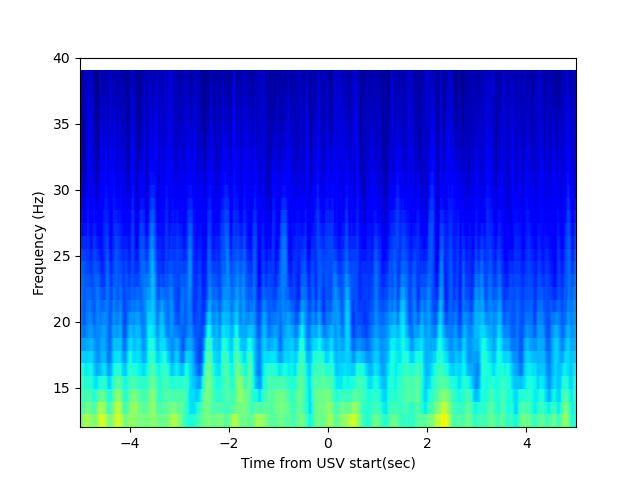

In [44]:
#short beta
usv_buffer_sec = (5, 5)
wv_beta_mean = wv_beta.get_pe_mean_spec(short_usv_epochs['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_beta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=beta_freq_lims)
ax.set_xlabel('Time from USV start(sec)')

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

Text(0.5, 0, 'Time from USV start(sec)')

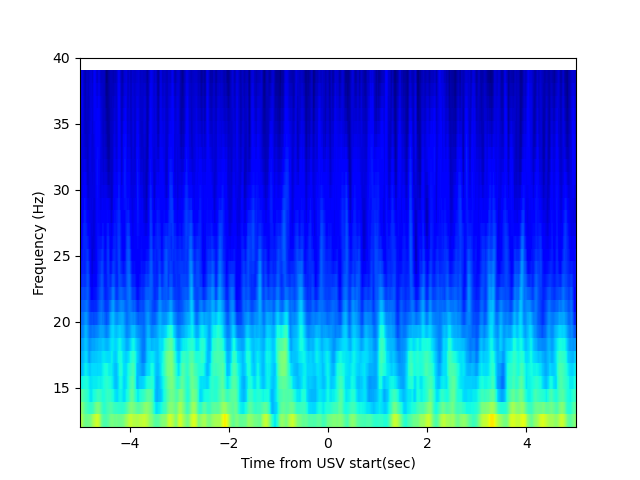

In [45]:
#long beta
usv_buffer_sec = (5, 5)
wv_beta_mean = wv_beta.get_pe_mean_spec(long_usv_epochs_filtered['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_beta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=beta_freq_lims)
ax.set_xlabel('Time from USV start(sec)')

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(4…

Text(0.5, 0, 'Time from USV start(sec)')

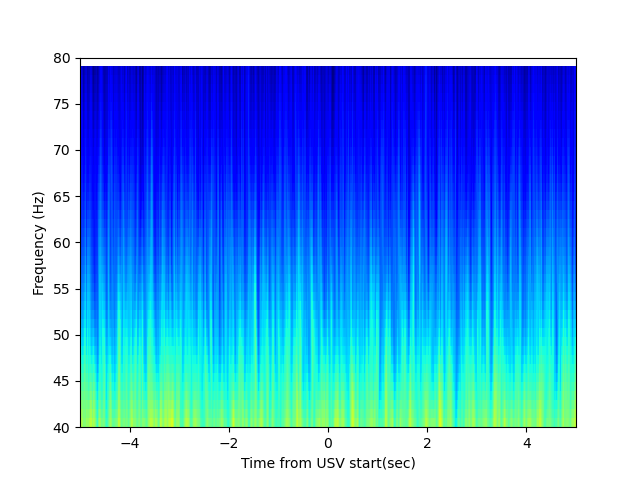

In [46]:
#Gamma
usv_buffer_sec = (5, 5)
wv_gamma_mean = wv_gamma.get_pe_mean_spec(usv_epochs.to_dataframe()['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_gamma_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=gamma_freq_lims)
ax.set_xlabel('Time from USV start(sec)')

## Finn recall7 note:
pyr channel (26) has weird-looking oscillations particularly during CS- and CS+(2) times.  I have used channel 20 instead which is well above the cell layer but has good-looking volume-conducted theta.  SWR detection appears to be fine using ch 26.

## Save notebook to working directory

In [47]:
from neuropy.utils.manipulate_files import save_notebook
save_notebook(sess.basepath, save_prepend=f"{animal}_{sess_name}_")

/data/GitHub/TraceFC/Notebooks/Animal_files/USV_Spectral_Analysis(Han).ipynb saved to /data2/Trace_FC/Recording_Rats/Han/2022_08_03_training/Han_training_USV_Spectral_Analysis(Han).ipynb


In [48]:
pip install jupyter-save-load-vars

Note: you may need to restart the kernel to use updated packages.
